# 2D Groundwater Model -- Steady-state

Consider confined groundwater flow in a homogeneous and isotropic aquifer with the size $[0, L] \times [0, L]$. Assume the aquifer thickness $b = 10 m$.

$$
Kb(\frac{\partial^2 h}{\partial x^2} + \frac{\partial^2 h}{\partial y^2}) + W + P = 0
$$
$$
h(x=0) = 40.0
$$
$$
h(x=L) = 60.0
$$
$$
K\frac{\partial h}{\partial y} \bigg\rvert_{y=0, y=L} = 0
$$

where, $W$ is groundwater injection, $P$ is groundwater pumping. Use MODFLOW 6 to simulate groundwater flow under steady-state condition.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import subprocess
import os
import flopy.utils.binaryfile as bf
from MF6_BASIC import MF6_basic as mf

In [2]:
# define grid
def generate_grid(L, nrow, ncol):
    xx = np.linspace(0, L, nrow+1)
    yy = np.linspace(0, L, ncol+1)
    dx = xx[1] - xx[0]
    dy = yy[1] - yy[0]
    xs = (xx[0:-1] + xx[1::]) / 2
    ys = (yy[0:-1] + yy[1::]) / 2
    centers = np.zeros((nrow * ncol, 4)) # row col X Y
    t = 0
    for i in range(len(ys)):
        for j in range(len(xs)):
            centers[t, 0] = i + 1
            centers[t, 1] = j + 1
            centers[t, 2] = xs[j]
            centers[t, 3] = ys[::-1][i]
            t += 1
    #
    return xx, yy, dx, dy, xs, ys, centers

In [3]:
# CHD data
def generate_chd(nrow, ncol):
    chd_list = np.zeros((2*nrow, 4))
    chd_list[:, 0] = 1
    chd_list[0:nrow, 1] = np.arange(nrow) + 1
    chd_list[0:nrow, 2] = 1
    chd_list[0:nrow, 3] = 40.0
    chd_list[nrow::, 1] = np.arange(nrow) + 1
    chd_list[nrow::, 2] = ncol
    chd_list[nrow::, 3] = 60.0
    #
    return chd_list

In [4]:
# WEL data
def generate_wel(centers, w1_loc, w2_loc, w1_rate, w2_rate):
    # WEL list
    wel_list = []

    dist = (centers[:, 2] - w1_loc[0]) ** 2 + (centers[:, 3] - w1_loc[1]) ** 2
    dist = dist ** 0.5
    ind = np.where(dist == np.min(dist))[0]
    wel_list.append([1, centers[ind[0]][0], centers[ind[0]][1], w1_rate])

    dist = (centers[:, 2] - w2_loc[0]) ** 2 + (centers[:, 3] - w2_loc[1]) ** 2
    dist = dist ** 0.5
    ind = np.where(dist == np.min(dist))[0]
    wel_list.append([1, centers[ind[0]][0], centers[ind[0]][1], w2_rate])
    #
    return wel_list

In [5]:
# simulation
def simulator(modelpath, modelname, nrow, ncol, dx, dy, K):
    # Wirte packages
    model = mf(modelpath, modelname, nrow, ncol, dx, dy, top = 10.0, bot = 0.0)
    model.write_dis()
    model.write_chd(chd_list)
    model.write_wel(wel_list)
    model.write_npf(K)
    model.write_ic(initial_head = 20.0)
    model.write_oc()
    model.write_tdis()
    # Run model
    rdir = os.getcwd()
    os.chdir(modelpath)
    r = subprocess.run('mf6.exe')
    os.chdir(rdir)
    # load head
    hdobj = bf.HeadFile(modelpath + modelname + ".hed")
    hdobj.list_records()
    rec = hdobj.get_data(idx=0)
    #
    return rec

In [6]:
# setup parameters
modelpath = 'Ex1_steady/'
modelname = 'ex1_steady'
L = 1000.0
nrow = 50
ncol = 50
K = 50.0
M = 10.0
w1_loc = (250.0, 760.0)
w2_loc = (770.0, 380.0)
w1_rate = 5000.0
w2_rate = -3000.0

In [7]:
xx, yy, dx, dy, xs, ys, centers = generate_grid(L, nrow, ncol)
chd_list = generate_chd(nrow, ncol)
wel_list = generate_wel(centers, w1_loc, w2_loc, w1_rate, w2_rate)

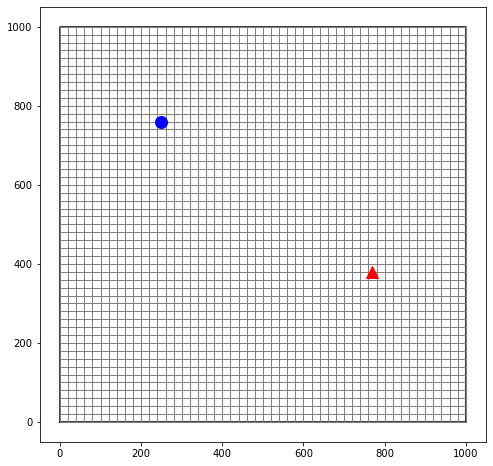

In [8]:
# plot grid
fig, ax = plt.subplots(1, figsize = (8, 8))
ax.plot([0, L, L, 0, 0], [0, 0, L, L, 0], color = 'black')
for i in yy:
    ax.plot([0, L], [yy, yy], color = 'grey', linewidth = 0.5)
for i in xx:
    ax.plot([xx, xx], [0, L], color = 'grey', linewidth = 0.5)
#ax.scatter(centers[:, 2], centers[:, 3], marker = 'o', color = 'black')
#ax.scatter(np.array([50]*10), ys, marker = 's', color = 'blue')
#ax.scatter(np.array([950]*10), ys, marker = 's', color = 'green')
#for i in range(len(ys)):
#    ax.text(-50, ys[::-1][i], i+1, ha = 'center', va = 'center', fontsize = 14)
#for i in range(len(xs)):
#    ax.text(xs[i], 1050, i+1, ha = 'center', va = 'center', fontsize = 14)
#ax.set_xlim([-100, 1100])
#ax.set_ylim([-100, 1100])
ax.plot(w1_loc[0], w1_loc[1], marker = 'o', markersize = 12, color = 'blue')
ax.plot(w2_loc[0], w2_loc[1], marker = '^', markersize = 12, color = 'red')

In [9]:
# Simulation
rec = simulator(modelpath, modelname, nrow, ncol, dx, dy, K = 25.0)

(1, 1, 1., 1., b'HEAD            ', 50, 50, 1)


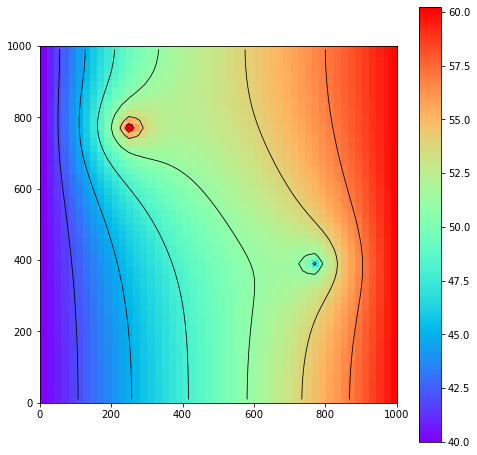

In [10]:
fig, ax = plt.subplots(1, figsize = (8, 8))
im = ax.imshow(rec[0], cmap = 'rainbow', extent = (0, L, 0, L))
fig.colorbar(im)
X, Y = np.meshgrid(xs, ys[::-1])
Z = rec[0]
ct = ax.contour(X, Y, Z, levels = 7, colors = 'black', linewidths = 0.8)
#ax.plot(w1_loc[0], w1_loc[1], marker = 'o', markersize = 12, color = 'blue')
#ax.plot(w2_loc[0], w2_loc[1], marker = '^', markersize = 12, color = 'red')

(1, 1, 1., 1., b'HEAD            ', 50, 50, 1)
(1, 1, 1., 1., b'HEAD            ', 50, 50, 1)
(1, 1, 1., 1., b'HEAD            ', 50, 50, 1)
(1, 1, 1., 1., b'HEAD            ', 50, 50, 1)


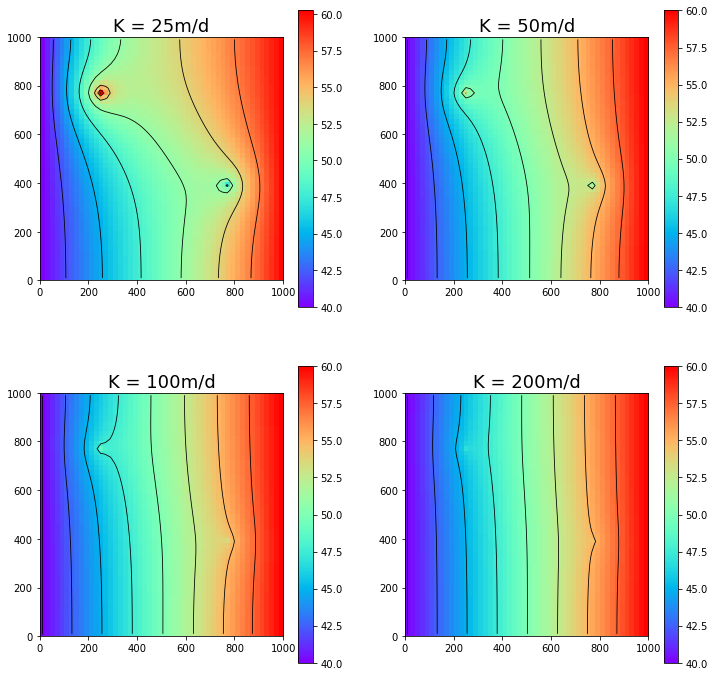

In [11]:
K_ls = [25.0, 50.0, 100.0, 200.0]
fig, axs = plt.subplots(2, 2, figsize = (12, 12))
for i in range(4):
    rr = i // 2
    cc = i % 2
    rec = simulator(modelpath, modelname, nrow, ncol, dx, dy, K = K_ls[i])
    im = axs[rr][cc].imshow(rec[0], cmap = 'rainbow', extent = (0, L, 0, L))
    fig.colorbar(im, ax = axs[rr][cc])
    Z = rec[0]
    ct = axs[rr][cc].contour(X, Y, Z, levels = 7, colors = 'black', linewidths = 0.8)
    axs[rr][cc].set_title('K = {}m/d'.format(int(K_ls[i])), fontsize = 18)